## Homework

In [1]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1OKFSv2GpuUFDphO0r8LdM7bl6MAWwBfX' -O data.csv

"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"id" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [4]:
df = pd.read_csv('C:/Users/Alina/Desktop/train.csv',  parse_dates=["timestamp"])
df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price
0,0,2014-12-26,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,36,7,2,15,33,1,12,75,10,15318960
1,1,2012-10-04,64,64.0,16.0,NaN,NaN,NaN,NaN,NaN,...,2,2,0,0,13,1,0,6,1,6080000
2,2,2014-02-05,83,44.0,9.0,17.0,1.0,1985.0,3.0,10.0,...,13,6,1,8,18,0,1,52,0,17000000
3,3,2012-07-26,71,49.0,2.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,3,0,2,8,2,990000
4,4,2014-10-29,60,42.0,9.0,9.0,1.0,1970.0,3.0,6.0,...,3,1,0,5,8,0,1,34,5,7900000


В этой домашней работе вы будете предсказывать стоимость домов по их характеристикам.

Метрика качества: `RMSE`

Оценивание:
* Baseline - 2 балла
* Feature Engineering - 2 балла
* Model Selection - 3 балла
* Ensemble v.1 - 3 балла
* (*) Ensemble v.2 - дополнительно, 2 балла

### Описание датасета

Короткое описание данных:
```
price: sale price (this is the target variable)
id: transaction id
timestamp: date of transaction
full_sq: total area in square meters, including loggias, balconies and other non-residential areas
life_sq: living area in square meters, excluding loggias, balconies and other non-residential areas
floor: for apartments, floor of the building
max_floor: number of floors in the building
material: wall material
build_year: year built
num_room: number of living rooms
kitch_sq: kitchen area
state: apartment condition
product_type: owner-occupier purchase or investment
sub_area: name of the district

The dataset also includes a collection of features about each property's surrounding neighbourhood, and some features that are constant across each sub area (known as a Raion). Most of the feature names are self explanatory, with the following notes. See below for a complete list.

full_all: subarea population
male_f, female_f: subarea population by gender
young_*: population younger than working age
work_*: working-age population
ekder_*: retirement-age population
n_m_{all|male|female}: population between n and m years old
build_count_*: buildings in the subarea by construction type or year
x_count_500: the number of x within 500m of the property
x_part_500: the share of x within 500m of the property
_sqm_: square meters
cafe_count_d_price_p: number of cafes within d meters of the property that have an average bill under p RUB
trc_: shopping malls
prom_: industrial zones
green_: green zones
metro_: subway
_avto_: distances by car
mkad_: Moscow Circle Auto Road
ttk_: Third Transport Ring
sadovoe_: Garden Ring
bulvar_ring_: Boulevard Ring
kremlin_: City center
zd_vokzaly_: Train station
oil_chemistry_: Dirty industry
ts_: Power plant
```

### Setup

In [3]:
import pandas as pd

In [5]:
#df = pd.read_csv("data.csv", parse_dates=["timestamp"])

In [6]:
df.shape

(20000, 292)

In [7]:
df.isna().sum()

id                       0
timestamp                0
full_sq                  0
life_sq               4103
floor                  113
                      ... 
mosque_count_5000        0
leisure_count_5000       0
sport_count_5000         0
market_count_5000        0
price                    0
Length: 292, dtype: int64

In [8]:
df.isna().any().sum()

51

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 292 entries, id to price
dtypes: datetime64[ns](1), float64(119), int64(157), object(15)
memory usage: 44.6+ MB


In [10]:
df.nunique()

id                    20000
timestamp              1148
full_sq                 195
life_sq                 155
floor                    39
                      ...  
mosque_count_5000         3
leisure_count_5000      107
sport_count_5000        214
market_count_5000        22
price                  6604
Length: 292, dtype: int64

Подготовим данные к разбиению на выборки

In [11]:
drop_columns = [
    'id',           # May leak information
    'timestamp',    # May leak information
]
cat_columns = [
    'product_type',              #
    'material',                  # Material of the wall
    'state',                     # Satisfaction level
    'sub_area',                  # District name
    'culture_objects_top_25',    #
    'thermal_power_plant_raion', #
    'incineration_raion',        #
    'oil_chemistry_raion',       #
    'radiation_raion',           #
    'railroad_terminal_raion',   #
    'big_market_raion',          #
    'nuclear_reactor_raion',     #
    'detention_facility_raion',  #
    'ID_metro',                  #
    'ID_railroad_station_walk',  #
    'ID_railroad_station_avto',  #
    'water_1line',               #
    'ID_big_road1',              #
    'big_road1_1line',           #
    'ID_big_road2',              #
    'railroad_1line',            #
    'ID_railroad_terminal',      #
    'ID_bus_terminal',           #
    'ecology',                   #
]
num_columns = list(set(df.columns).difference(set(cat_columns + drop_columns)))

In [12]:
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

df1 = pd.DataFrame(df, copy=True)
df1.drop(columns=drop_columns, inplace=True)

mis_replacer = SimpleImputer(strategy="median")
df1[num_columns] = mis_replacer.fit_transform(df1[num_columns])

mis_replacer = SimpleImputer(strategy="most_frequent")
df1[cat_columns] = mis_replacer.fit_transform(df1[cat_columns])

In [13]:
df1.isna().any().sum()

0

In [14]:
def find_cat(data, num_uniq=4):
    for name in data.columns:
        s = ''
        s += name
        if (type(data[name][0]) == str):
            s += ' строка,'
        if (data[name].nunique()<=num_uniq):
            s += ' мало уникальных'
        if (s!=name):
            print (s)
            
find_cat(df1)

product_type строка, мало уникальных
sub_area строка,
school_education_centers_top_20_raion мало уникальных
university_top_20_raion мало уникальных
culture_objects_top_25 строка, мало уникальных
thermal_power_plant_raion строка, мало уникальных
incineration_raion строка, мало уникальных
oil_chemistry_raion строка, мало уникальных
radiation_raion строка, мало уникальных
railroad_terminal_raion строка, мало уникальных
big_market_raion строка, мало уникальных
nuclear_reactor_raion строка, мало уникальных
detention_facility_raion строка, мало уникальных
build_count_foam мало уникальных
water_1line строка, мало уникальных
big_road1_1line строка, мало уникальных
railroad_1line строка, мало уникальных
ecology строка,
cafe_count_500_price_high мало уникальных
mosque_count_500 мало уникальных
mosque_count_1000 мало уникальных
mosque_count_1500 мало уникальных
mosque_count_2000 мало уникальных
mosque_count_3000 мало уникальных
mosque_count_5000 мало уникальных


In [15]:
df2 = pd.get_dummies(df1)

In [16]:
df1.shape, df2.shape

((20000, 290), (20000, 452))

Разделите имеющиеся у вас данные на обучающую и тестовую выборки. В качестве обучающей выборки возьмите первые 80% данных, последние 20% - тестовая выборка.

In [17]:
import plotly.express as px
px.histogram(df2.price)


In [18]:
from sklearn.model_selection import train_test_split

X = df2.drop(columns='price', axis = 1)
Y = df2['price']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [19]:
X_train#, X_test, y_train, y_test

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,water_1line_yes,big_road1_1line_no,big_road1_1line_yes,railroad_1line_no,railroad_1line_yes,ecology_excellent,ecology_good,ecology_no data,ecology_poor,ecology_satisfactory
5894,96.0,96.0,3.0,12.0,1.0,1979.0,2.0,6.0,2.0,7.307411e+06,...,0,1,0,1,0,1,0,0,0,0
3728,64.0,33.0,2.0,17.0,1.0,2014.0,2.0,12.0,3.0,3.879802e+06,...,0,1,0,1,0,0,1,0,0,0
8958,73.0,30.0,17.0,17.0,1.0,1979.0,2.0,1.0,1.0,1.139168e+07,...,0,1,0,1,0,0,1,0,0,0
7671,60.0,30.0,4.0,18.0,1.0,1.0,2.0,1.0,2.0,1.084231e+07,...,0,1,0,1,0,0,0,1,0,0
5999,40.0,30.0,9.0,12.0,1.0,1979.0,2.0,6.0,2.0,1.139168e+07,...,0,1,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,46.0,28.0,4.0,12.0,5.0,1972.0,2.0,9.0,3.0,8.087656e+06,...,0,1,0,1,0,1,0,0,0,0
11964,46.0,46.0,10.0,12.0,1.0,1979.0,2.0,6.0,2.0,6.677245e+07,...,0,1,0,1,0,0,0,1,0,0
5390,72.0,72.0,2.0,25.0,4.0,2015.0,2.0,1.0,1.0,1.163805e+07,...,0,1,0,1,0,0,0,0,1,0
860,82.0,30.0,8.0,12.0,1.0,1979.0,2.0,6.0,2.0,6.677245e+07,...,0,1,0,1,0,0,0,1,0,0


Возможно в ваших моделях вам придется указывать, какие колонки являются категориальными (например, в бустингах). Для упрощения предлагается разделить колонки по следующему принципу:
```
drop_columns = [
    'id',           # May leak information
    'timestamp',    # May leak information
]
cat_columns = [
    'product_type',              #
    'material',                  # Material of the wall
    'state',                     # Satisfaction level
    'sub_area',                  # District name
    'culture_objects_top_25',    #
    'thermal_power_plant_raion', #
    'incineration_raion',        #
    'oil_chemistry_raion',       #
    'radiation_raion',           #
    'railroad_terminal_raion',   #
    'big_market_raion',          #
    'nuclear_reactor_raion',     #
    'detention_facility_raion',  #
    'ID_metro',                  #
    'ID_railroad_station_walk',  #
    'ID_railroad_station_avto',  #
    'water_1line',               #
    'ID_big_road1',              #
    'big_road1_1line',           #
    'ID_big_road2',              #
    'railroad_1line',            #
    'ID_railroad_terminal',      #
    'ID_bus_terminal',           #
    'ecology',                   #
]
num_columns = list(set(df.columns).difference(set(cat_columns + drop_columns)))
```

### Baseline (2 балла)

В качестве Baseline обучите `DecisionTreeRegressor` из `sklearn`.

In [21]:
from sklearn.tree import plot_tree, DecisionTreeRegressor

decisionTree = DecisionTreeRegressor(random_state=42)
decisionTree.fit(X_train, y_train)
pred = decisionTree.predict(X_test)


In [ ]:
#plot_tree(decision_tree=decisionTree)

Проверьте качество на отложенной выборке.

In [22]:
from sklearn.metrics import mean_squared_error
import numpy as np

np.sqrt(mean_squared_error(pred, y_test))

3829189.7199571165

### Feature Engineering (2 балла)

Часто улучшить модель можно с помощью аккуратного Feature Engineering.

Добавим в модель дополнительные признаки:
* "Как часто в этот год и этот месяц появлились объявления"
* "Как часто в этот год и эту неделю появлялись объявления"

In [23]:
month_year = (df.timestamp.dt.month + df.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df2["month_year_cnt"] = month_year.map(month_year_cnt_map)

week_year = (df.timestamp.dt.weekofyear + df.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df2["week_year_cnt"] = week_year.map(week_year_cnt_map)

<ipython-input-23-43aece23f0cc>:5: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



Добавьте следюущие дополнительные признаки:
* Месяц (из колонки `timestamp`)
* День недели (из колонки `timestamp`)
* Отношение "этаж / максимальный этаж в здании" (колонки `floor` и `max_floor`)
* Отношение "площадь кухни / площадь квартиры" (колонки `kitchen_sq` и `full_sq`)

По желанию можно добавить и другие признаки.

In [24]:
df2["month"] = df.timestamp.dt.month
df2["weekday"] = df.timestamp.dt.weekday
df2["floor_max"] = df2.floor / df2.max_floor
df2["kitchen_full"] = df2.kitch_sq / df2.full_sq

In [25]:
df2.columns

Index(['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year',
       'num_room', 'kitch_sq', 'state', 'area_m',
       ...
       'ecology_good', 'ecology_no data', 'ecology_poor',
       'ecology_satisfactory', 'month_year_cnt', 'week_year_cnt', 'month',
       'weekday', 'floor_max', 'kitchen_full'],
      dtype='object', length=458)

In [34]:
df2.isna().sum()

full_sq          0
life_sq          0
floor            0
max_floor        0
material         0
                ..
week_year_cnt    0
month            0
weekday          0
floor_max        2
kitchen_full     1
Length: 458, dtype: int64

In [54]:
df2.isna().sum()

full_sq          0
life_sq          0
floor            0
max_floor        0
material         0
                ..
week_year_cnt    0
month            0
weekday          0
floor_max        0
kitchen_full     0
Length: 458, dtype: int64

In [46]:
df2.dropna(inplace=True)

In [47]:
df2.shape

(19997, 458)

Разделите выборку на обучающую и тестовую еще раз (потому что дополнительные признаки созданы для исходной выборки).

In [59]:
df2.isna().any().sum()

0

In [60]:
df2.dtypes

full_sq          float64
life_sq          float64
floor            float64
max_floor        float64
material         float64
                  ...   
week_year_cnt      int64
month              int64
weekday            int64
floor_max        float64
kitchen_full     float64
Length: 458, dtype: object

In [61]:
df2.replace([np.inf, -np.inf], np.nan, inplace=True)
df2.fillna(df2.mean(), inplace=True)

In [62]:
X = df2.drop(columns='price', axis = 1)
Y = df2['price']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Model Selection (3 балла)

Посмотрите, какого качества можно добиться если использовать разные модели:
* `DecisionTreeRegressor` из `sklearn`
* `RandomForestRegressor` из `sklearn`
* `CatBoostRegressor`

Также вы можете попробовать линейные модели, другие бустинги (`LigthGBM` и `XGBoost`).

Почти все библиотеки поддерживают удобный способ подбора гиперпараметров: посмотрите как это делать в [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) или в [catboost](https://catboost.ai/docs/concepts/python-reference_catboostregressor_grid_search.html).

Проверяйте качество каждой модели на тестовой выборке и выберите наилучшую.

In [63]:
from sklearn.ensemble import RandomForestRegressor
import catboost as cb

In [64]:
decisionTree = DecisionTreeRegressor(random_state=42)
decisionTree.fit(X_train, y_train)
decisionTree_pred = decisionTree.predict(X_test)

forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)
forest_pred = forest.predict(X_test)

yandex = cb.CatBoostRegressor(random_state=42)
yandex.fit(X_train, y_train)
yandex_pred = yandex.predict(X_test)

Learning rate set to 0.063448
0:	learn: 4459955.2499965	total: 185ms	remaining: 3m 5s
1:	learn: 4325655.6766504	total: 214ms	remaining: 1m 46s
2:	learn: 4201086.5598023	total: 243ms	remaining: 1m 20s
3:	learn: 4080238.4376363	total: 276ms	remaining: 1m 8s
4:	learn: 3972512.9995205	total: 308ms	remaining: 1m 1s
5:	learn: 3871186.9324211	total: 337ms	remaining: 55.9s
6:	learn: 3776659.1541953	total: 369ms	remaining: 52.4s
7:	learn: 3696482.4840971	total: 406ms	remaining: 50.3s
8:	learn: 3622637.1980508	total: 438ms	remaining: 48.2s
9:	learn: 3543899.1358343	total: 477ms	remaining: 47.2s
10:	learn: 3480405.2103055	total: 524ms	remaining: 47.1s
11:	learn: 3421420.3789742	total: 565ms	remaining: 46.5s
12:	learn: 3366786.5666721	total: 600ms	remaining: 45.6s
13:	learn: 3309785.8108253	total: 648ms	remaining: 45.6s
14:	learn: 3254915.9106870	total: 687ms	remaining: 45.1s
15:	learn: 3210745.3275304	total: 728ms	remaining: 44.8s
16:	learn: 3167782.1484398	total: 767ms	remaining: 44.4s
17:	learn

In [67]:

metrics = [decisionTree_pred, forest_pred, yandex_pred]
strings = ['DecisionTreeRegressor', 'RandomForestRegressor', 'CatBoostRegressor']

for m in range(3):
    print(f'model: {strings[m]}')
    print(f'RMSE: {round(np.sqrt(mean_squared_error(metrics[m], y_test)), 3)}')
    print('-'*30, '\n')

model: DecisionTreeRegressor
RMSE: 3865973.204
------------------------------ 

model: RandomForestRegressor
RMSE: 2716664.344
------------------------------ 

model: CatBoostRegressor
RMSE: 2579658.663
------------------------------ 



Это полученные значения с базовыми моделями, попробуем посмотреть как мы можем улучшить результат через  подбор оптимальных параметров

Постороим графики зависимости результата от параметров

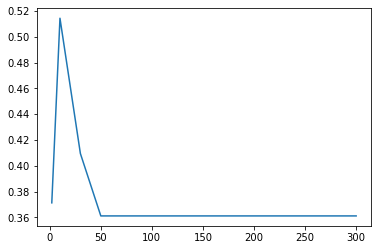

In [68]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from collections import Counter

accuracies = []

ranges = [2, 10, 30, 50, 100, 150, 200, 300]
for depth in ranges:
  dtree = DecisionTreeRegressor(max_depth=depth, random_state=42)
  dtree.fit(X_train, y_train)
  accuracies.append(dtree.score(X_test, y_test))

plt.plot(list(ranges), accuracies)

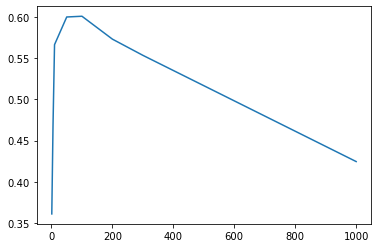

In [70]:
accuracies = []

ranges = [1, 5, 10, 50, 100, 200, 300, 1000]
for min_samples_leaf in ranges:
  dtree = DecisionTreeRegressor(min_samples_leaf=min_samples_leaf, random_state=42)
  dtree.fit(X_train, y_train)
  accuracies.append(dtree.score(X_test, y_test))

plt.plot(list(ranges), accuracies)

In [71]:
from sklearn.model_selection import GridSearchCV

dtree = DecisionTreeRegressor()
parameters = {"max_depth":[2, 10, 30, 50, 100, 150, 200, 300], "min_samples_leaf":[1, 5, 10, 50, 100, 200, 300, 1000]}
gs_tree = GridSearchCV(dtree, param_grid=parameters, scoring="neg_mean_squared_error", cv=5)
gs_tree.fit(X_train, y_train)
gs_tree.best_params_

{'max_depth': 10, 'min_samples_leaf': 50}

In [73]:
dtree = DecisionTreeRegressor(max_depth=10 ,min_samples_leaf=50, random_state=42)
dtree.fit(X_train, y_train)
dtree_pred1 = dtree.predict(X_test)

np.sqrt(mean_squared_error(dtree_pred1, y_test))

3047801.250331922

Как видим показатель значительно улучшился

Посмотрим как выглядит наше дерево

[Text(0.6531936813186813, 0.9545454545454546, 'X[0] <= 70.5\nsquared_error = 21308448536147.17\nsamples = 15997\nvalue = 7109590.498'),
 Text(0.3787774725274725, 0.8636363636363636, 'X[0] <= 49.5\nsquared_error = 6897947681288.047\nsamples = 12990\nvalue = 6026032.148'),
 Text(0.2032967032967033, 0.7727272727272727, 'X[249] <= 5.5\nsquared_error = 3973860315426.508\nsamples = 7993\nvalue = 5286416.138'),
 Text(0.08983516483516484, 0.6818181818181818, 'X[11] <= 0.499\nsquared_error = 1069433369679.432\nsamples = 1918\nvalue = 3950459.02'),
 Text(0.05, 0.5909090909090909, 'X[0] <= 37.5\nsquared_error = 897535290251.674\nsamples = 1698\nvalue = 4120322.93'),
 Text(0.017582417582417582, 0.5, 'X[258] <= 793.775\nsquared_error = 877215968279.748\nsamples = 420\nvalue = 3591868.71'),
 Text(0.008791208791208791, 0.4090909090909091, 'X[115] <= 1.129\nsquared_error = 1275693629669.356\nsamples = 166\nvalue = 3963805.669'),
 Text(0.004395604395604396, 0.3181818181818182, 'squared_error = 16674443

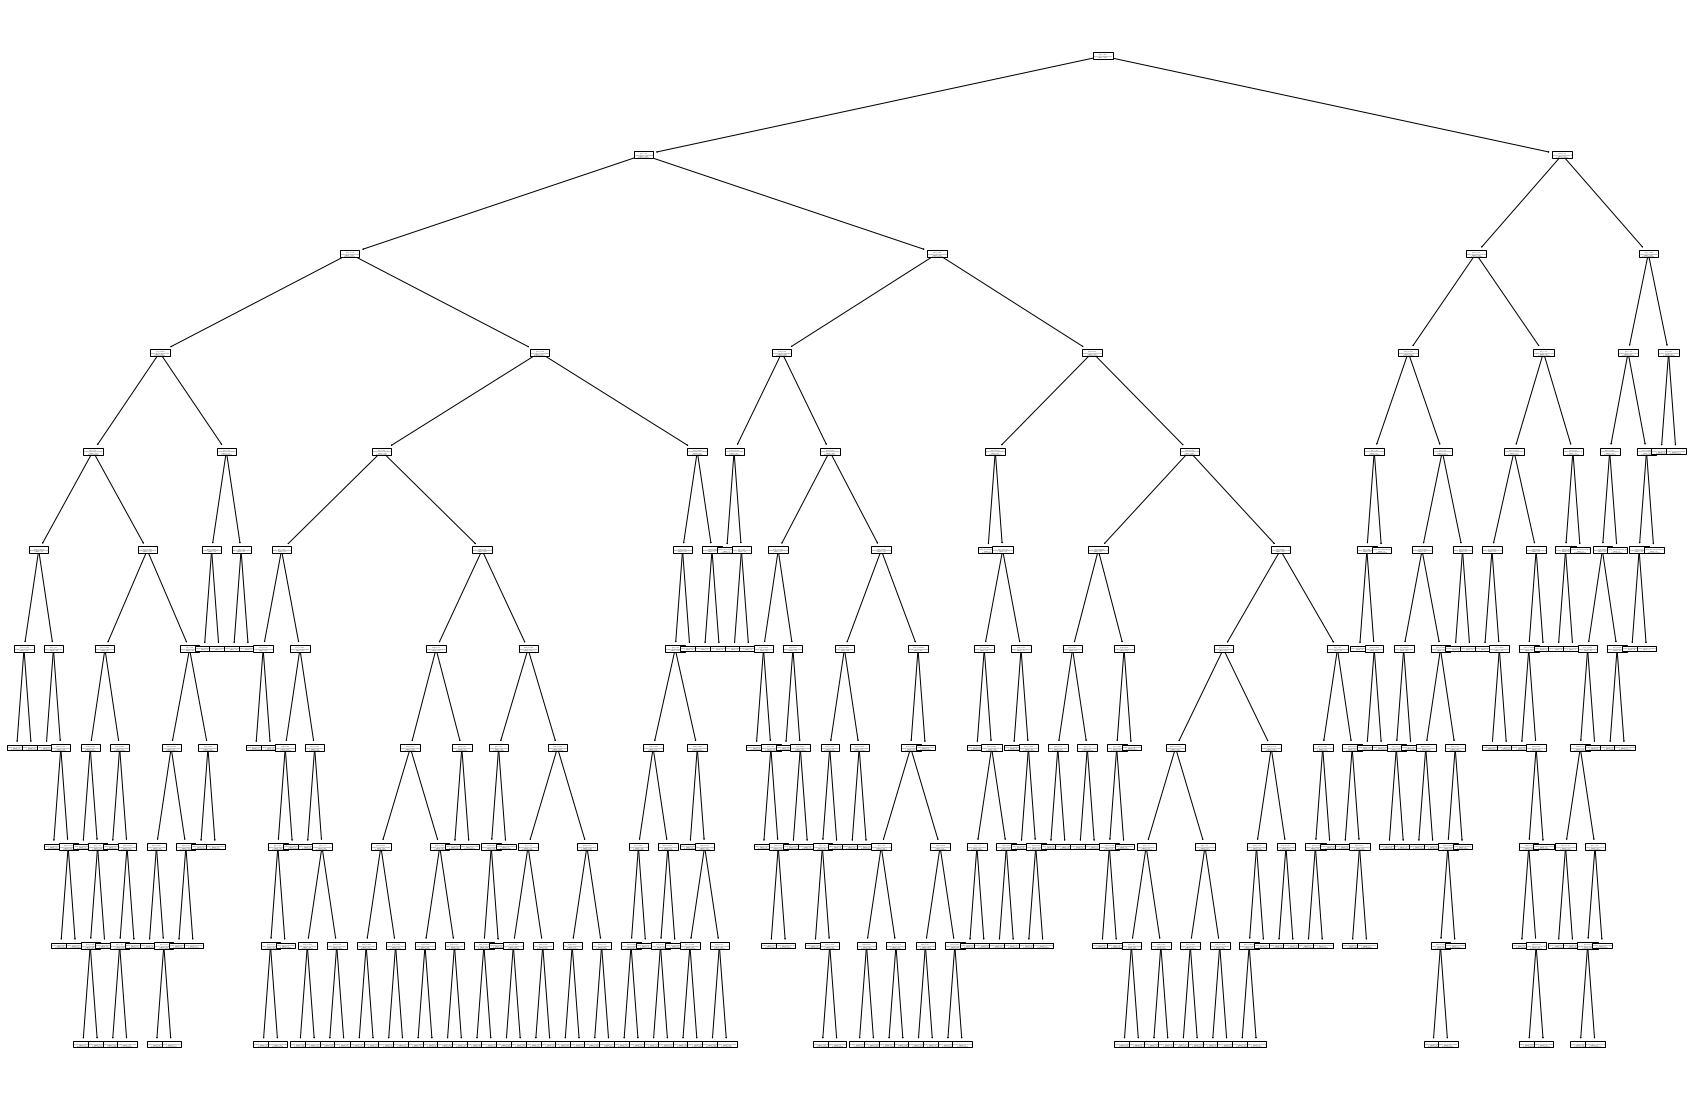

In [75]:
figure = plt.figure(figsize=(30, 20))
plot_tree(dtree)

Посмотрим что можно сделать с лесом 

In [ ]:
forest = RandomForestRegressor(min_samples_leaf=100, random_state=42)
grid_param = {
'n_estimators': [20, 50, 100, 200, 500],
'max_features': ['auto'],
'bootstrap': [True, False],
'max_depth': [10, 100, 200, 500]
}
gs_forest = GridSearchCV(forest,
                      param_grid=grid_param,
                      scoring="neg_mean_squared_error",
                      cv=5)
gs_forest.fit(X_train, y_train)
gs_forest.best_params_

In [ ]:
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)
forest_pred = forest.predict(X_test)

np.sqrt(mean_squared_error(forest_pred, y_test))

Как видим CatBoostRegressor справился лучше всего

### Ensemble v.1 (3 балла)

Ансамбли иногда оказываются лучше чем одна большая модель.

В колонке `product_type` содержится информация о том, каким является объявление: `Investment` (продажа квартиры как инвестиции) или `OwnerOccupier` (продажа квартиры для жилья). Логично предположить, что если сделать по модели на каждый из этих типов, то качество будет выше.

Обучите свои лучшие модели на отдельно на `Investment` и `OwnerOccupier` (т.е. у вас будет `model_invest`, обученная на `(invest_train_X, invest_train_Y)` и `model_owner`, обученная на `(owner_train_X, owner_train_Y)`) и проверьте качество на отложенной выборке (т.е. на исходном `test_split`).

In [89]:
df = pd.read_csv('C:/Users/Alina/Desktop/train.csv',  parse_dates=["timestamp"])
df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price
0,0,2014-12-26,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,36,7,2,15,33,1,12,75,10,15318960
1,1,2012-10-04,64,64.0,16.0,NaN,NaN,NaN,NaN,NaN,...,2,2,0,0,13,1,0,6,1,6080000
2,2,2014-02-05,83,44.0,9.0,17.0,1.0,1985.0,3.0,10.0,...,13,6,1,8,18,0,1,52,0,17000000
3,3,2012-07-26,71,49.0,2.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,3,0,2,8,2,990000
4,4,2014-10-29,60,42.0,9.0,9.0,1.0,1970.0,3.0,6.0,...,3,1,0,5,8,0,1,34,5,7900000


In [90]:
df = pd.get_dummies(df , columns = cat_columns)

In [91]:
X_train.loc[:, "price"] = y_train
invest = X_train.loc[X_train["product_type_Investment"] == 1, :]

owner = X_train.loc[X_train["product_type_OwnerOccupier"] == 1, :]


In [92]:
invest_train_X = invest.drop(columns="price")
invest_train_Y = invest["price"]

In [93]:
owner_train_X = invest.drop(columns="price")
owner_train_Y = invest["price"]

Так как CatBoost оказался лучше всего, то используем его 

In [94]:
X_test[X_test["product_type_Investment"] == 1]


,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,...,ecology_good,ecology_no data,ecology_poor,ecology_satisfactory,month_year_cnt,week_year_cnt,month,weekday,floor_max,kitchen_full
10749,52.0,30.0,2.0,12.0,1.0,1976.0,2.0,8.0,3.0,9.282439e+06,...,0,0,1,0,249,91,1,4,0.166667,0.153846
3352,77.0,46.0,22.0,22.0,1.0,1989.0,3.0,9.0,2.0,1.175477e+07,...,0,0,0,0,861,277,6,5,1.000000,0.116883
3125,46.0,30.0,2.0,12.0,1.0,1978.0,2.0,6.0,2.0,7.632940e+06,...,0,0,1,0,834,256,11,4,0.166667,0.130435
17927,56.0,35.0,3.0,8.0,2.0,1959.0,2.0,8.0,2.0,7.798452e+06,...,0,0,1,0,734,181,9,2,0.375000,0.142857
6660,43.0,28.0,7.0,9.0,1.0,1970.0,2.0,6.0,3.0,1.803644e+07,...,0,0,0,1,1122,278,12,2,0.777778,0.139535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4904,34.0,21.0,7.0,9.0,1.0,1987.0,1.0,6.0,3.0,7.462270e+06,...,0,0,1,0,861,129,6,0,0.777778,0.176471
7855,50.0,30.0,8.0,12.0,1.0,1979.0,2.0,6.0,2.0,1.175477e+07,...,0,0,0,0,165,56,1,5,0.666667,0.120000
3728,64.0,33.0,2.0,17.0,1.0,2014.0,2.0,12.0,3.0,3.879802e+06,...,1,0,0,0,391,80,3,3,0.117647,0.187500
16543,57.0,39.0,6.0,9.0,1.0,1973.0,3.0,6.0,3.0,1.020722e+07,...,1,0,0,0,574,106,10,1,0.666667,0.105263


In [95]:
from catboost import CatBoostRegressor

model_invest = CatBoostRegressor(loss_function="RMSE", random_state=42, depth=7,
                          iterations=500, learning_rate=0.15, verbose=False)
model_invest.fit(invest_train_X, invest_train_Y)
model_invest_pred = model_invest.predict(X_test[X_test["product_type_Investment"] == 1])



In [96]:
model_owner = CatBoostRegressor(loss_function="RMSE", random_state=42, depth=7,
                          iterations=500, learning_rate=0.15, verbose=False)
model_owner.fit(owner_train_X, owner_train_Y)
model_owner_pred = model_owner.predict(X_test[X_test["product_type_OwnerOccupier"] == 1])

In [97]:
boost_invest_pred_indexed = pd.Series(model_invest_pred, index=X_test[X_test["product_type_Investment"] == 1].index)
boost_owner_pred_indexed = pd.Series(model_owner_pred, index=X_test[X_test["product_type_OwnerOccupier"] == 1].index)
prediction = pd.concat((boost_invest_pred_indexed, boost_owner_pred_indexed))
prediction = prediction[y_test.index]


In [98]:
np.sqrt(mean_squared_error(prediction, y_test))

2940667.9721105634

### (*) Ensemble v.2 (дополнительно, 2 балла)

Попробуйте сделать для `Investment` более сложную модель: обучите `CatBoostRegressor` и `HuberRegressor` из `sklearn`, а затем сложите их предсказания с весами `w_1` и `w_2` (выберите веса сами; сумма весов равняется 1).

In [102]:
from sklearn.linear_model import HuberRegressor
huber = HuberRegressor(max_iter=3000).fit(X=invest_train_X, y=invest_train_Y)
huber_pred = huber.predict(X_test[X_test["product_type_Investment"] == 1])

In [105]:
np.sqrt(mean_squared_error(huber_pred, model_invest_pred))

4259202.984582589